In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import comb

In [3]:
def simulate_tmrca_delta0(n, rng):
    """
    Simulate TMRCA for Kingman's coalescent (Lambda = delta_0)
    starting from n lineages.
    """
    t = 0.0
    b = n
    while b > 1:
        lambda_b = b * (b - 1) / 2.0  # total rate of any binary merger
        wait = rng.exponential(1.0 / lambda_b)
        t += wait
        b -= 1  # binary merger: b -> b-1
    return t

# -----------------------------------------------------------
# 2. Simulation of TMRCA for Lambda = delta_x (Dirac at x)
# -----------------------------------------------------------

def simulate_tmrca_delta_x(n, x, rng):
    """
    Simulate TMRCA for a Lambda-coalescent with Lambda = delta_x on [0,1].

    Rates:
      lambda_{b,k} = x^{k-2} (1-x)^{b-k}
      weight_{b,k} = C(b,k) * lambda_{b,k}
      lambda_b = sum_k weight_{b,k}
      p_{b,k} = weight_{b,k} / lambda_b

    After a k-merger, the number of blocks goes b -> b - k + 1.
    """
    t = 0.0
    b = n
    while b > 1:
        ks = np.arange(2, b + 1)
        lambda_bk = (x ** (ks - 2)) * ((1.0 - x) ** (b - ks))  # shape (b-1,)
        weights = np.array([comb(b, int(k)) for k in ks], dtype=float) * lambda_bk
        lambda_b = weights.sum()

        # holding time
        wait = rng.exponential(1.0 / lambda_b)
        t += wait

        # choose merger size k
        probs = weights / lambda_b
        k = rng.choice(ks, p=probs)

        # update number of blocks
        b = b - int(k) + 1

    return t

# -----------------------------------------------------------
# 3. Theoretical means
# -----------------------------------------------------------

def theoretical_mean_delta0(n):
    """
    E_tau for Kingman's coalescent starting from n lineages:
      E[τ] = 2 * (1 - 1/n).
    """
    return 2.0 * (1.0 - 1.0 / n)


def theoretical_mean_delta_x(n, x):
    """
    Theoretical mean TMRCA for Lambda = delta_x, via the recursion
      H(1) = 0
      H(b) = 1/lambda_b + sum_{k=2}^b p_{b,k} H(b-k+1),
    where
      lambda_{b,k} = x^{k-2} (1-x)^{b-k}
      weight_{b,k} = C(b,k) * lambda_{b,k}
      lambda_b = sum_k weight_{b,k}
      p_{b,k} = weight_{b,k} / lambda_b.
    """
    H = np.zeros(n + 1)  # H[b] = E[τ | N_0 = b], H[1] = 0

    for b in range(2, n + 1):
        ks = np.arange(2, b + 1)
        lambda_bk = (x ** (ks - 2)) * ((1.0 - x) ** (b - ks))
        weights = np.array([comb(b, int(k)) for k in ks], dtype=float) * lambda_bk
        lambda_b = weights.sum()
        probs = weights / lambda_b

        # Next number of blocks is b-k+1, for each k
        next_states = b - ks + 1
        expected_future = np.sum(probs * H[next_states])

        H[b] = 1.0 / lambda_b + expected_future

    return H[n]

# -----------------------------------------------------------
# 4. Confidence interval (normal approximation)
# -----------------------------------------------------------

def mean_and_ci(samples, alpha=0.05):
    """
    Return empirical mean, standard deviation and (1-alpha) CI for the mean.
    Normal approximation with z-quantiles.
    """
    samples = np.asarray(samples)
    N = samples.size
    mean = samples.mean()
    std = samples.std(ddof=1)
    se = std / np.sqrt(N)

    from scipy.stats import norm
    z = norm.ppf(1.0 - alpha / 2.0)

    ci_low = mean - z * se
    ci_high = mean + z * se
    return mean, std, (ci_low, ci_high)

# -----------------------------------------------------------
# 5. Main experiment
# -----------------------------------------------------------


# Parameters
n = 8
x = 0.25  # delta_{1/4}
N_sim = 100000
alpha = 0.05

rng = np.random.default_rng(seed=42)

# Simulations
tmrca_delta0 = np.array([simulate_tmrca_delta0(n, rng) for _ in range(N_sim)])
tmrca_delta_x = np.array([simulate_tmrca_delta_x(n, x, rng) for _ in range(N_sim)])

# Empirical statistics + CIs
mean0_emp, std0_emp, ci0 = mean_and_ci(tmrca_delta0, alpha=alpha)
meanx_emp, stdx_emp, cix = mean_and_ci(tmrca_delta_x, alpha=alpha)

# Theoretical means
mean0_th = theoretical_mean_delta0(n)
meanx_th = theoretical_mean_delta_x(n, x)

print(f"n = {n}, N_sim = {N_sim}, alpha = {alpha}")
print("----- delta_0 (Kingman) -----")
print(f"Empirical mean       = {mean0_emp:.6f}")
print(f"Theoretical mean     = {mean0_th:.6f}")
print(f"95% CI for the mean  = [{ci0[0]:.6f}, {ci0[1]:.6f}]")
print()
print("----- delta_{1/4} -----")
print(f"Empirical mean       = {meanx_emp:.6f}")
print(f"Theoretical mean     = {meanx_th:.6f}")
print(f"95% CI for the mean  = [{cix[0]:.6f}, {cix[1]:.6f}]")


n = 8, N_sim = 100000, alpha = 0.05
----- delta_0 (Kingman) -----
Empirical mean       = 1.744562
Theoretical mean     = 1.750000
95% CI for the mean  = [1.737931, 1.751194]

----- delta_{1/4} -----
Empirical mean       = 1.758926
Theoretical mean     = 1.759966
95% CI for the mean  = [1.752001, 1.765852]


In [5]:
from matplotlib.patches import Rectangle, ConnectionPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

C:\Users\Le R\AppData\Local\Temp\ipykernel_11108\4170957294.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{abs(y):.2f}" for y in yticks])
C:\Users\Le R\AppData\Local\Temp\ipykernel_11108\4170957294.py:174: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


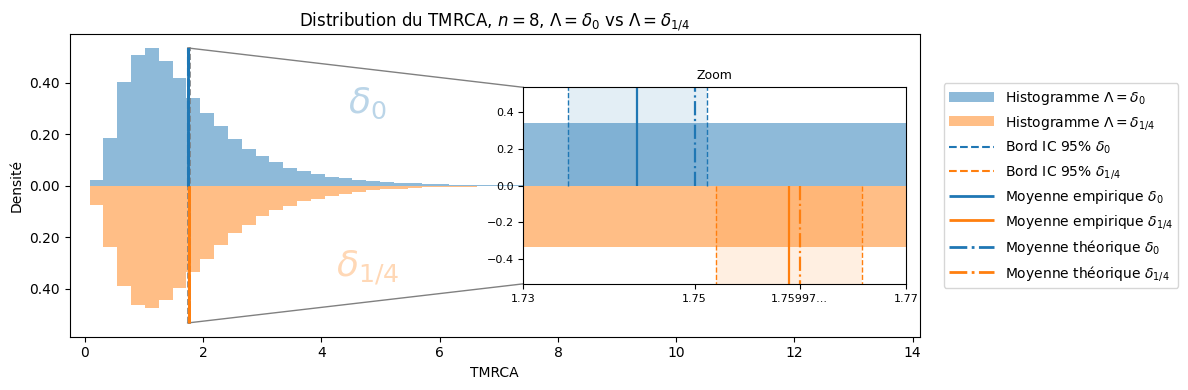

In [29]:
all_samples = np.concatenate([tmrca_delta0, tmrca_delta_x])
xmin, xmax = all_samples.min(), all_samples.max()
margin = 0.05 * (xmax - xmin)
xmin -= margin
xmax += margin

nbins = 60
bins = np.linspace(xmin, xmax, nbins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_width = bins[1] - bins[0]

# Histogrammes (densités)
hist0, _ = np.histogram(tmrca_delta0, bins=bins, density=True)
histx, _ = np.histogram(tmrca_delta_x, bins=bins, density=True)

# Couleurs
c0 = "#1f77b4"  # delta_0 (haut)
c1 = "#ff7f0e"  # delta_{1/4} (bas)

fig, ax = plt.subplots(figsize=(12, 4))

# Vers le haut pour delta_0
ax.bar(
    bin_centers,
    hist0,
    width=bin_width,
    align="center",
    alpha=0.5,
    color=c0,
    label=r"Histogramme $\Lambda = \delta_0$",
)

# Vers le bas pour delta_{1/4}
ax.bar(
    bin_centers,
    -histx,
    width=bin_width,
    align="center",
    alpha=0.5,
    color=c1,
    label=r"Histogramme $\Lambda = \delta_{1/4}$",
)

# Limites: marge à gauche légère (conservée) et axes symétriques
ymax = max(hist0.max(), histx.max())
ax.set_ylim(-1.1 * ymax, 1.1 * ymax)
ax.set_xlim(-margin * 0.4)  # garde votre marge personnalisée
yticks = ax.get_yticks()
ax.set_yticklabels([f"{abs(y):.2f}" for y in yticks])

# Intervalles de confiance: bords pointillés + bande verticale remplie
# delta_0 (haut)
ax.vlines(ci0[0], 0, ymax, colors=c0, linestyles="--", linewidth=1.5, label=r"Bord IC 95% $\delta_0$")
ax.vlines(ci0[1], 0, ymax, colors=c0, linestyles="--", linewidth=1.5)
ax.add_patch(Rectangle((ci0[0], 0), ci0[1] - ci0[0], ymax, facecolor=c0, alpha=0.1, edgecolor="none"))

# delta_{1/4} (bas)
ax.vlines(cix[0], 0, -ymax, colors=c1, linestyles="--", linewidth=1.5, label=r"Bord IC 95% $\delta_{1/4}$")
ax.vlines(cix[1], 0, -ymax, colors=c1, linestyles="--", linewidth=1.5)
ax.add_patch(Rectangle((cix[0], -ymax), cix[1] - cix[0], ymax, facecolor=c1, alpha=0.1, edgecolor="none"))

# Moyennes: empirique (plein) et théorique (pointillé)
# delta_0 (haut)
ax.vlines(mean0_emp, 0, ymax, colors=c0, linestyles="-", linewidth=2, label=r"Moyenne empirique $\delta_0$")
ax.vlines(mean0_th, 0, ymax, colors=c0, linestyles="-.", linewidth=2, label=r"Moyenne théorique $\delta_0$")
# delta_{1/4} (bas)
ax.vlines(meanx_emp, 0, -ymax, colors=c1, linestyles="-", linewidth=2, label=r"Moyenne empirique $\delta_{1/4}$")
ax.vlines(meanx_th, 0, -ymax, colors=c1, linestyles="-.", linewidth=2, label=r"Moyenne théorique $\delta_{1/4}$")

# Libellés FR
ax.set_xlabel(r"TMRCA")
ax.set_ylabel("Densité")
ax.set_title(rf"Distribution du TMRCA, $n={n}$, $\Lambda=\delta_0$ vs $\Lambda=\delta_{{1/4}}$")
# ax.grid(True, alpha=0.3)

# Gros labels au centre (LaTeX, alpha 0.3), décalés vers la gauche
x_lo_view, x_hi_view = ax.get_xlim()
x_text = x_lo_view + 0.35 * (x_hi_view - x_lo_view)
ax.text(x_text,  0.6 * ymax, r"$\delta_0$",     color=c0, alpha=0.3, ha="center", va="center", fontsize=26, fontweight="bold")
ax.text(x_text, -0.6 * ymax, r"$\delta_{1/4}$", color=c1, alpha=0.3, ha="center", va="center", fontsize=26, fontweight="bold")

# Légende à l'extérieur avec ordre bleu puis orange
handles, labels = ax.get_legend_handles_labels()

def _type_key(lbl):
    if "Histogramme" in lbl or "Histogram" in lbl:
        return 0
    if "Bord IC" in lbl or "CI edge" in lbl:
        return 1
    if "Moyenne empirique" in lbl or "Empirical mean" in lbl:
        return 2
    if "Moyenne théorique" in lbl or "Theoretical mean" in lbl:
        return 3
    return 4

def _color_key(lbl):
    # bleu (delta_0) d'abord, puis orange (delta_{1/4})
    if "delta_0" in lbl or "\delta_0" in lbl or "δ_0" in lbl:
        return 0
    if "delta_{1/4}" in lbl or "\delta_{1/4}" in lbl or "δ_{1/4}" in lbl:
        return 1
    return 2

order = sorted(range(len(labels)), key=lambda i: (_type_key(labels[i]), _color_key(labels[i])))
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]
ax.legend(handles, labels, loc="center left", bbox_to_anchor=(1.02, 0.5), ncol=1, frameon=True, handlelength=3.2)
# ax.legend(
#     handles,
#     labels,
#     loc="center left",
#     bbox_to_anchor=(1.02, 0.325, 0.26, 0.325),  # élargit la fenêtre de légende
#     bbox_transform=ax.transAxes,
#     mode="expand",
#     ncol=1,
#     frameon=True,
#     handlelength=3.2,     # icônes plus longs
#     # handletextpad=1.0,    # plus d'espace entre icône et texte
#     columnspacing=1.2,
# )

# -----------------------------
# Inset zoom sur la zone d'IC (à droite)
# -----------------------------
# Fenêtre de zoom autour des IC combinées
x_lo = min(ci0[0], cix[0])
x_hi = max(ci0[1], cix[1])
span = x_hi - x_lo
pad = 0.15 * span if span > 0 else 0.05
x_lo -= pad
x_hi += pad
zoom_y = ymax

# Axe inséré à droite
axins = inset_axes(ax, width="45%", height="65%", loc="center right", borderpad=1.0)

# Replot histogrammes dans l'inset
axins.bar(bin_centers, hist0, width=bin_width, align="center", alpha=0.5, color=c0)
axins.bar(bin_centers, -histx, width=bin_width, align="center", alpha=0.5, color=c1)

# Bandes d'IC et lignes de moyennes dans l'inset
axins.add_patch(Rectangle((ci0[0], 0), ci0[1] - ci0[0], zoom_y, facecolor=c0, alpha=0.12, edgecolor="none"))
axins.add_patch(Rectangle((cix[0], -zoom_y), cix[1] - cix[0], zoom_y, facecolor=c1, alpha=0.12, edgecolor="none"))
axins.vlines([ci0[0], ci0[1]], 0, zoom_y, colors=c0, linestyles="--", linewidth=1.0)
axins.vlines([cix[0], cix[1]], 0, -zoom_y, colors=c1, linestyles="--", linewidth=1.0)
axins.vlines(mean0_emp, 0, zoom_y, colors=c0, linestyles="-", linewidth=1.6)
axins.vlines(mean0_th, 0, zoom_y, colors=c0, linestyles="-.", linewidth=1.6)
axins.vlines(meanx_emp, 0, -zoom_y, colors=c1, linestyles="-", linewidth=1.6)
axins.vlines(meanx_th, 0, -zoom_y, colors=c1, linestyles="-.", linewidth=1.6)

axins.set_xlim(x_lo, x_hi)
axins.set_ylim(-zoom_y, zoom_y)
# Vos ticks personnalisés conservés
axins.set_xticks([x_lo, mean0_th, meanx_th, x_hi])
axins.set_xticklabels([f"{x_lo:.2f}", f"{mean0_th:.2f}", f"{meanx_th:.5f}...", f"{x_hi:.2f}"])
axins.tick_params(axis="both", labelsize=8)
# axins.grid(True, alpha=0.25)
axins.set_title("Zoom", fontsize=9)

# Cadre de zoom sur l'axe principal (gris pointillé)
zoom_rect = Rectangle((x_lo, -zoom_y), x_hi - x_lo, 2 * zoom_y, fill=False, edgecolor="gray", linewidth=1.2, linestyle="--")
ax.add_patch(zoom_rect)

# Connecteurs: même côté (droite) — pointent vers les coins droits de l'inset
con_tr = ConnectionPatch(xyA=(x_hi,  zoom_y),  coordsA=ax.transData,
                         xyB=(0, 1),           coordsB=axins.transAxes,
                         color="gray", linewidth=1.0)
con_br = ConnectionPatch(xyA=(x_lo, -zoom_y),  coordsA=ax.transData,
                         xyB=(0, 0),           coordsB=axins.transAxes,
                         color="gray", linewidth=1.0)
ax.add_artist(con_tr)
ax.add_artist(con_br)

plt.tight_layout()
plt.show()

In [30]:
fig.savefig("plot_tmrca_extrema_histograms.svg", dpi=300)